In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, concatenate, Activation, \
MaxPooling2D, Conv2D, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

import numpy as np
import pandas as pd
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/datasets/Лица.zip'

In [ ]:
images_dir = 'Лица'
img_height = 112
img_width = 80

In [ ]:
# Функция загрузки изображений
def load_images(images_dir, img_height, img_width):
  list_img = []
  for img in os.listdir(images_dir):
    list_img.append(image.img_to_array(image.load_img
                                       (os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  print('OK')
  return np.array(list_img)

In [ ]:
cur_time = time.time()
xTrain_img = load_images(images_dir, img_height, img_width)
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

OK
Время загрузки: 34.37с


In [ ]:
xTrain_img = xTrain_img/255
xTrain_img.shape

(5018, 112, 80, 1)

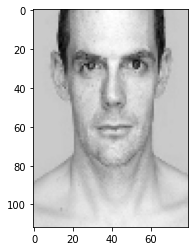

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112, 80), cmap='gray')
plt.show()

In [ ]:
# функцию создания базового автокодировщика
def baseAutoencoder(shape=(112, 80, 1)):
    img_input = Input((shape))
    # входные данные передаем на слой двумерной свёртки
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # передаем на слой двумерной свёртки
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    z = MaxPooling2D()(x)
    
    # слой разжимает данные(с 28*20 на 56*40)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x)
    
    # передаем на слой двумерной свёртки
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    # Сжатие MaxPooling2D не применяем

    # слой разжимает данные(с 56*40 на 112*80)
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model = Model(img_input, x)

    # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') 

    return model

In [ ]:
modelAutoFace = baseAutoencoder() # создаем автокодировщик
modelAutoFace.fit(xTrain_img[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data = (xTrain_img[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 5s 102ms/step - loss: 0.0362 - val_loss: 0.0684
Epoch 2/150
47/47 [==============================] - 5s 98ms/step - loss: 0.0110 - val_loss: 0.0697
Epoch 3/150
47/47 [==============================] - 5s 98ms/step - loss: 0.0074 - val_loss: 0.0686
Epoch 4/150
47/47 [==============================] - 5s 98ms/step - loss: 0.0059 - val_loss: 0.0646
Epoch 5/150
47/47 [==============================] - 5s 97ms/step - loss: 0.0052 - val_loss: 0.0593
Epoch 6/150
47/47 [==============================] - 5s 97ms/step - loss: 0.0048 - val_loss: 0.0522
Epoch 7/150
47/47 [==============================] - 5s 97ms/step - loss: 0.0042 - val_loss: 0.0402
Epoch 8/150
47/47 [==============================] - 5s 98ms/step - loss: 0.0040 - val_loss: 0.0268
Epoch 9/150
47/47 [==============================] - 5s 97ms/step - loss: 0.0038 - val_loss: 0.0188
Epoch 10/150
47/47 [==============================] - 5s 98ms/step - loss: 0.0036 - val_loss: 0.012

In [ ]:
# modelAutoFace.save_weights('modelAutoFace.h5') # Сохраняем модель
modelAutoFace.load_weights('modelAutoFace.h5') # Сохраняем модель

In [ ]:
# создадим функцию для вывода изображений как картинок
def plotImages(xTrain, pred, shape=(112, 80)): 
  
  n = 7  
  plt.figure(figsize=(10, 4))
  for i in range(n):
      index = np.random.randint(0, pred.shape[0])
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(xTrain[index].reshape(shape))     
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(pred[index].reshape(shape))    
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
# создадим функцию среднеквадратичной ошибки
def getMSE(x1, x2): 
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  # и возвращаем сумму квадратов разницы, делённую на длину разницы
  return sum(delta ** 2) / len(delta) 

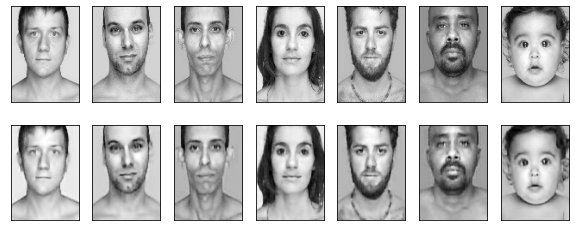

In [ ]:
predFace = modelAutoFace.predict(xTrain_img[:100])
predFace = predFace * 255
predFace = predFace.astype('uint8')
plotImages(xTrain_img, predFace)

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFace = [getMSE(xTrain_img[i], predFace[i] / 255) for i in range(len(predFace))]
print("Ошибка на Лицах:", errFace[80:])
print("Средняя ошибка на Лицах:", round(sum(errFace[80:]) / len(errFace[80:]), 4))
print("Минимальная ошибка на Лицах:", round(min(errFace),4))


Ошибка на Лицах: [0.001174203507630269, 0.0006817726542004008, 0.0007215428020280141, 0.0013972410797898052, 0.0005574970068118324, 0.0006203885105531364, 0.002901567867072287, 0.0006280415964123303, 0.0009230399292402404, 0.0009948955809357867, 0.0006092163997368871, 0.0009435042277105603, 0.001380765490103965, 0.0005546236683864536, 0.0009477795152802448, 0.002481001659618542, 0.0014365615796605837, 0.0009989599299649295, 0.0008805218128552405, 0.0006411822469143214]
Средняя ошибка на Лицах: 0.0011
Минимальная ошибка на Лицах: 0.0004


In [ ]:
# установим какое-то пороговое значение
bias = 0.004 
isFace = [e < bias for e in errFace[80:]]
print("Лица распознаны, как Лица: ", round(100*sum(isFace) / len(isFace)),"%", sep="")

Лица распознаны, как Лица: 100.0%


In [ ]:
# создаем 100 картинок шума
noise = np.random.sample((100,112,80,1)) 
print(noise.shape)

(100, 112, 80, 1)


In [ ]:
# сделаем предикт этих шумовых картинок
predNoise = modelAutoFace.predict(noise[:100]) 
predNoise = predNoise * 255 
predNoise = predNoise.astype('uint8') 

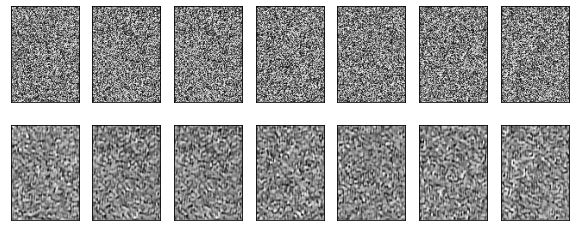

In [ ]:
# выведем на экран исходные шумовые картинки и восстановленые 
plotImages(noise, predNoise) 

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для Mnist и для шумовых изображений
errN = [getMSE(noise[i], predNoise[i] / 255) for i in range(len(predFace))]
print("Ошибка на Лицах:", errFace[0:20])
print("Ошибка на шуме:", errN[0:20])
print("Средняя ошибка на Лицах:", round(sum(errFace) / len(errFace), 4))
print("Средняя ошибка на шуме:", round(sum(errN) / len(errN), 4))
print("Максимальная ошибка на Лицах:", round(max(errFace),4))
print("Минимальная ошибка на шуме:", round(min(errN),4))

Ошибка на Лицах: [0.0007477262219458681, 0.0015730008317132154, 0.000898445982211114, 0.0014193633413138369, 0.0008514945997095916, 0.0014779327011456326, 0.0015771957651327933, 0.0004490531310005585, 0.0007194246892677276, 0.001039768545975978, 0.0023756420437026356, 0.0009869298436472218, 0.0009241177158572039, 0.0007959354594007358, 0.000691022258724373, 0.0011129495458812161, 0.0007380901335675661, 0.0006532398076478328, 0.0010833558006554756, 0.0008245199954056117]
Ошибка на шуме: [0.06573147970945398, 0.06400110464387587, 0.06537290858618795, 0.06492538203813887, 0.06478171121565991, 0.06425931452121296, 0.06595392956417952, 0.06536461677951005, 0.06611591982828044, 0.06448025421749227, 0.06503161898356559, 0.06503959731300474, 0.06565320167533029, 0.06458409590827381, 0.06563782221174266, 0.0655003493748777, 0.0664614329048454, 0.06488082205235761, 0.06588025691845377, 0.06543157537773564]
Средняя ошибка на Лицах: 0.0012
Средняя ошибка на шуме: 0.0651
Максимальная ошибка на Лица

In [ ]:
# объявим функцию добавления шума
def addNoise(x, noiseVal): 
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) 
  return np.clip(x + noiseVal * noise, 0., 1.) 

In [ ]:
# cоздаем зашумленный вариант лиц из xTrain_img
noisedXTrainFace = addNoise(xTrain_img, 0.4) 

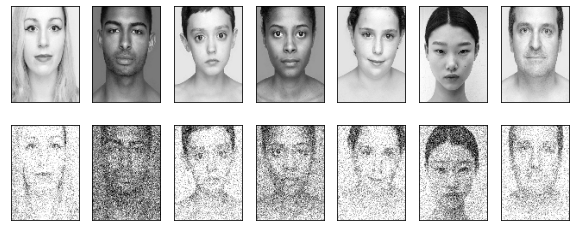

In [ ]:
# выведем на экран исходные лица и зашумленные варианты 
plotImages(xTrain_img, noisedXTrainFace) 

In [ ]:
# объявляем функцию создания автокодировщика для подавления шума
def denoiseAutoencoder(): 
    img_input = Input((112,80,1))

    # Добавляем четыре сверточных слоя, вместо MaxPooling используем strides
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    # сплющиваем в одномерный вектор - размер 7*5*256
    x = Flatten()(x) 
    z = Dense(256, activation='relu')(x)
    # и еще полносвязный слой с переводом в 8960-мерное пространство(7*5*256)
    x = Dense(7*5*256, activation='relu')(z) 
    # меняем размеры - картинка 7*5 , 256 ядер
    x = Reshape((7,5,256))(x) 
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) 
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model = Model(img_input, x)
    # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
    model.compile(optimizer='adam', loss='mse') 
                  
    return model

In [ ]:
modelDenoiseFace = denoiseAutoencoder()
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
modelDenoiseFace.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=80, batch_size=100, 
                     validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]))


Epoch 1/80
47/47 [==============================] - 2s 50ms/step - loss: 0.0595 - val_loss: 0.0458
Epoch 2/80
47/47 [==============================] - 2s 47ms/step - loss: 0.0299 - val_loss: 0.0215
Epoch 3/80
47/47 [==============================] - 2s 47ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 4/80
47/47 [==============================] - 2s 46ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 5/80
47/47 [==============================] - 2s 46ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 6/80
47/47 [==============================] - 2s 46ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 7/80
47/47 [==============================] - 2s 46ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 8/80
47/47 [==============================] - 2s 47ms/step - loss: 0.0095 - val_loss: 0.0106
Epoch 9/80
47/47 [==============================] - 2s 46ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 10/80
47/47 [==============================] - 2s 46ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 11/

In [ ]:
# modelDenoiseFace.save_weights('modelDenoiseFace.h5') # Сохраняем модель
modelDenoiseFace.load_weights('modelDenoiseFace.h5') # Сохраняем модель

In [ ]:
# подаем 4тыс зашумленных картинок и делаем предикт
predFaceDenoise = modelDenoiseFace.predict(noisedXTrainFace[:4000]) 
predFaceDenoise = predFaceDenoise * 255 
predFaceDenoise = predFaceDenoise.astype('uint8') 

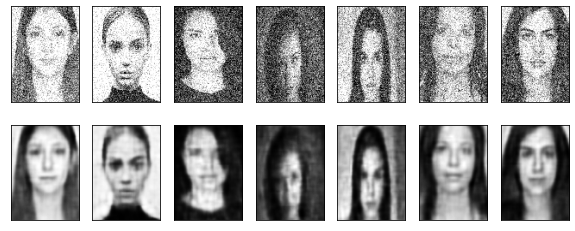

In [ ]:
plotImages(noisedXTrainFace, predFaceDenoise) # взглянем как отрабатывает шумоподавление на зашумленных картинках

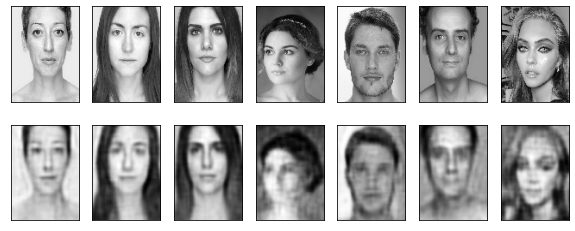

In [ ]:
plotImages(xTrain_img, predFaceDenoise) # взглянем как отрабатывает шумоподавление на лицах